In [1]:
# produce combined FHC+RHC event rates before background subtraction

In [2]:
import sys

sys.path.insert(0, 'backend_functions')

import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb


import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT

import top 
from top import *

import uncertainty_functions 
from uncertainty_functions import *

import xsec_functions 
from xsec_functions import smear_matrix

from ROOT import TH1D, TH2D, TDirectory, TH1F, TH2F

from selection_functions import *

Welcome to JupyROOT 6.18/00


In [3]:
import io
import json
import os
from datetime import date

In [4]:
xvar = 'tksh_angle'
true_var = 'opening_angle'

bins = [-1, -0.5, np.cos(100 * np.pi/180), np.cos(80 * np.pi/180), 0.5, 1]
x_ticks = [-1, -0.5, -0.174, 0.174, 0.5, 1]


xlow = bins[0]
xhigh = bins[-1]

x_label = "cos $\\theta_{ep}$"

In [5]:
if xvar=='tksh_angle': 
    bincenters = 0.5*(np.array(x_ticks)[1:]+np.array(x_ticks)[:-1])

else: 
    bincenters = 0.5*(np.array(x_ticks+[xhigh])[1:]+np.array(x_ticks+[xhigh])[:-1])

In [6]:
with open('unfolding/variations/full_event_rates/FHCVariations_FullEvtRate_'+xvar+'.json') as f_fhc:
        fhc_dict = json.load(f_fhc)
        
with open('unfolding/variations/full_event_rates/RHCVariations_FullEvtRate_'+xvar+'.json') as f_rhc:
        rhc_dict = json.load(f_rhc)

In [7]:
binwidth = []

for x in range(len(bincenters)): 
    binwidth.append(round(abs((x_ticks+[xhigh])[x+1]-(x_ticks+[xhigh])[x])/2, 2))  
    
binwidth

[0.25, 0.16, 0.17, 0.16, 0.25]

In [8]:
fhc_dict.keys()

dict_keys(['full_evt_rate', 'beamon_full_evt_rate', 'ppfx', 'beamline', 'genie_ms', 'genie_us', 'geant4', 'pot_counting', 'dirt', 'cv_dirt', 'cv_bkgd', 'cv_ext', 'mc_bkgd_sumw2', 'ext_sumw2', 'mc_signal_sumw2'])

In [9]:
# compute the neutrino event rate (no EXT) for covariance calculation

fhc_ncv_nu = [a-b for a,b in zip(fhc_dict['full_evt_rate'], fhc_dict['cv_ext'])]
rhc_ncv_nu = [a-b for a,b in zip(rhc_dict['full_evt_rate'], rhc_dict['cv_ext'])]
ncv_nu = [a+b for a,b in zip(fhc_ncv_nu, rhc_ncv_nu)]


In [10]:
len(bins)

6

## PPFX

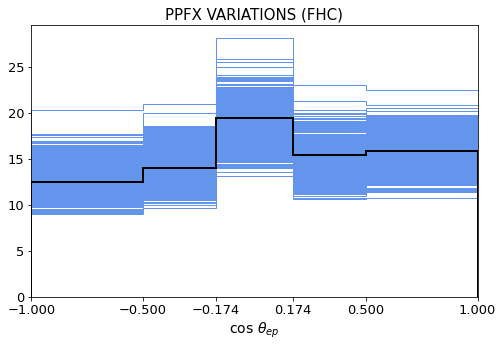

In [11]:
fig = plt.figure(figsize=(8, 5)) 

for v in fhc_dict['ppfx']: 
    
    plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=v,
        histtype='step', color='cornflowerblue', linewidth=1)

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=fhc_dict['full_evt_rate'],
        histtype='step', color='black', linewidth=2)    

plt.xlim(xlow, xhigh)
plt.title("PPFX VARIATIONS (FHC)", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)

plt.show()

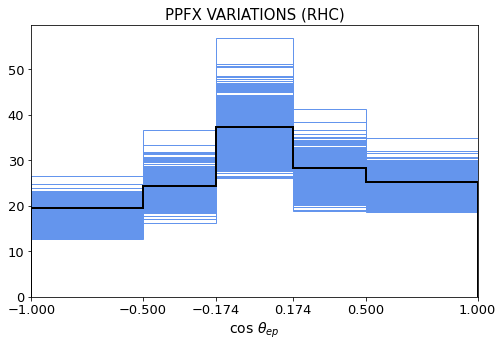

In [12]:

fig = plt.figure(figsize=(8, 5)) 

for v in rhc_dict['ppfx']: 
    
    plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=v,
        histtype='step', color='cornflowerblue', linewidth=1)

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=rhc_dict['full_evt_rate'],
        histtype='step', color='black', linewidth=2) 
    
plt.xlim(xlow, xhigh)
plt.title("PPFX VARIATIONS (RHC)", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)
plt.show()

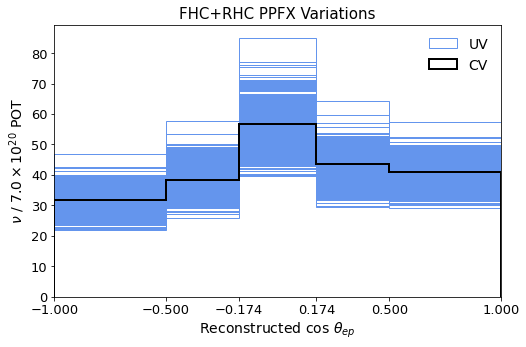

In [13]:
ppfx_variations = []

fig = plt.figure(figsize=(8, 5)) 

n = 0

for v_fhc, v_rhc in zip(fhc_dict['ppfx'], rhc_dict['ppfx']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    ppfx_variations.append(comb_v)
    
    if n==0: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1, label='UV')
    else: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1)
        
    
    n+=1

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC PPFX Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=14, frameon=False)

plt.xlabel('Reconstructed '+x_label, fontsize=14)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/ppfx_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [14]:
rhc_ppfx_dict = calcCov(xvar, bins, rhc_ncv_nu, rhc_dict['full_evt_rate'], 
                    rhc_dict['ppfx'], plot=False,  save=False, xticks=x_ticks, xhigh=xhigh) 

number of universes =  600


In [15]:
fhc_ppfx_dict = calcCov(xvar, bins, fhc_ncv_nu, fhc_dict['full_evt_rate'], 
                    fhc_dict['ppfx'], plot=False, 
                    save=False, xticks=x_ticks, xhigh=xhigh) 

number of universes =  600


number of universes =  600


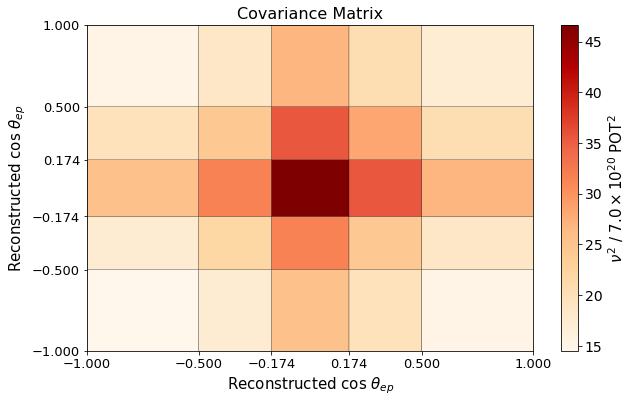

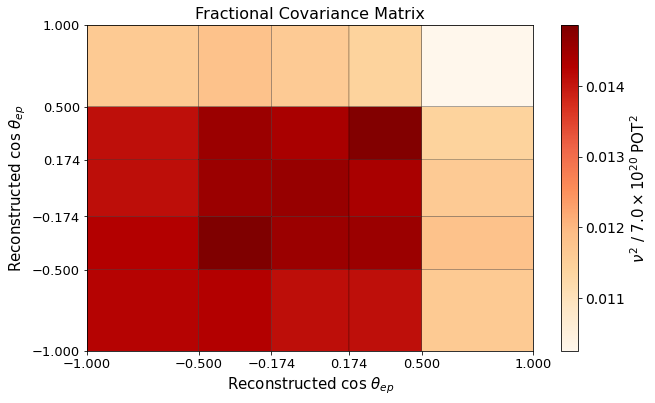

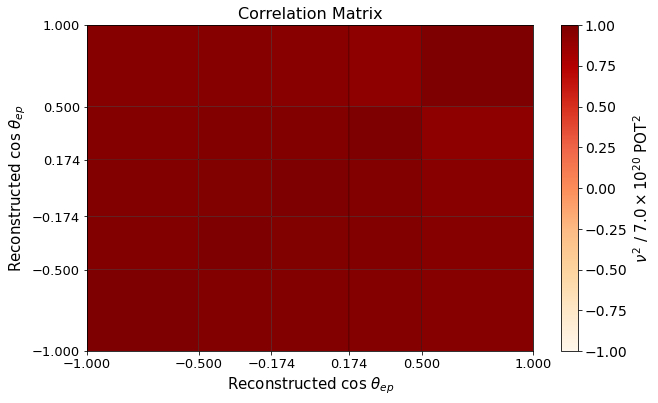

In [16]:
## calculate covariance 

ppfx_dict = calcCov(xvar, bins, ncv_nu, 
                    [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])], 
                    ppfx_variations, plot=True, xticks=x_ticks, xhigh=xhigh, 
                    axis_label='Reconstructed '+x_label, pot='$7.0 \\times 10^{20}$ POT') 
                    #save="/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/ppfx_") 

In [17]:
rhc_ppfx_dict['fractional_uncertainty']

array([0.11958108, 0.12143954, 0.12293031, 0.12438877, 0.09673332])

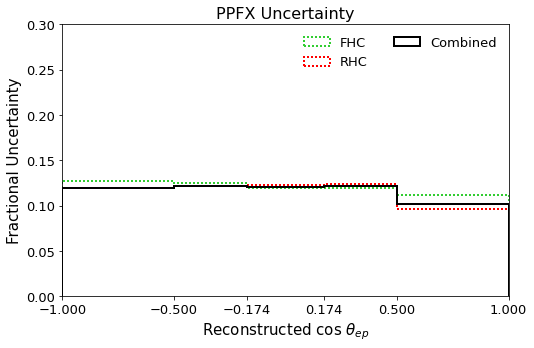

In [18]:
fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_ppfx_dict['fractional_uncertainty'], linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_ppfx_dict['fractional_uncertainty'], linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=ppfx_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.3)

plt.legend(fontsize=13, frameon=False, ncol=2)
plt.title("PPFX Uncertainty", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/ppfx_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## Beamline Geometry 

In [19]:
beamline_runs = ['HornCurrent', 'xHorn1', 'yHorn1', 'BeamSpotSize', 'xHorn2', 'yHorn2', 'WaterOnHorns', 
                'xBeamShift', 'yBeamShift', 'zTargetPosition']

HornCurrent


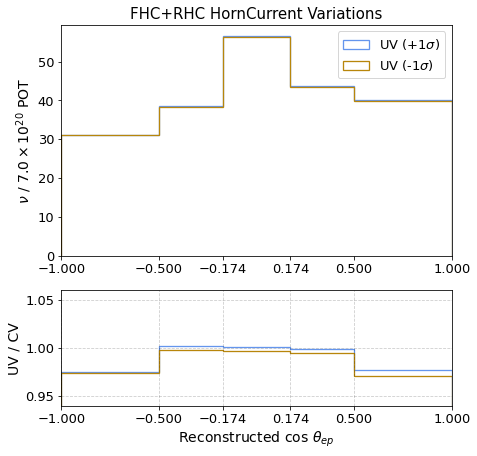

number of universes =  2
number of universes =  2
number of universes =  2
xHorn1


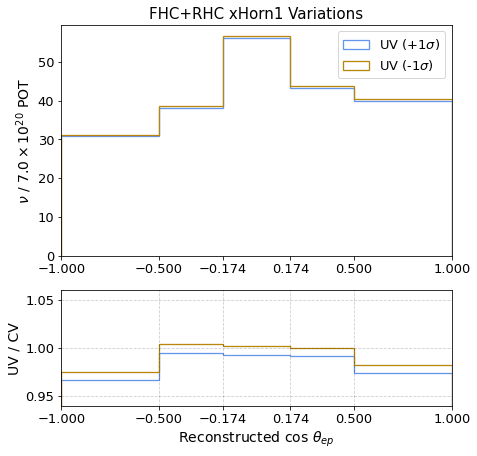

number of universes =  2
number of universes =  2
number of universes =  2
yHorn1


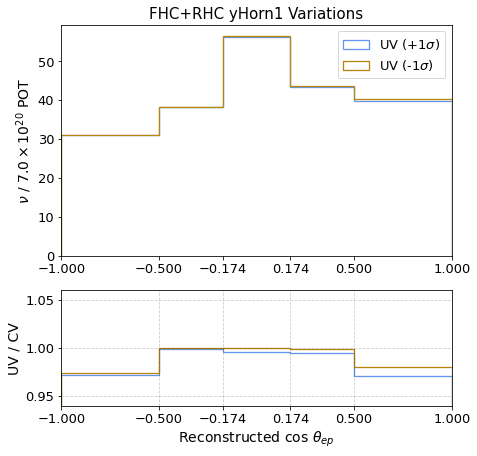

number of universes =  2
number of universes =  2
number of universes =  2
BeamSpotSize


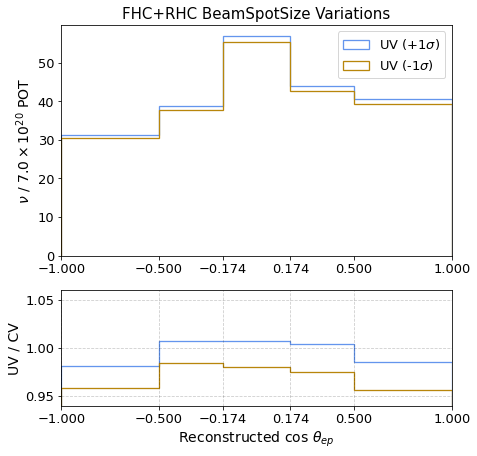

number of universes =  2
number of universes =  2
number of universes =  2
xHorn2


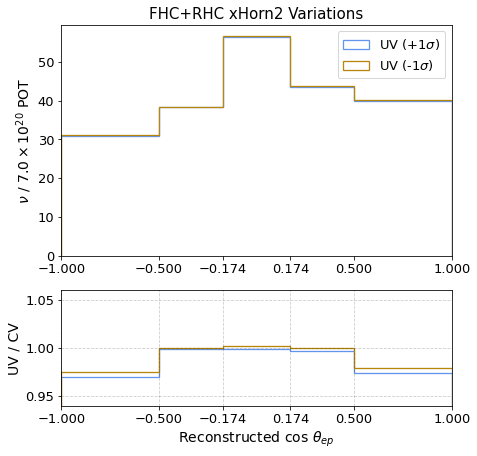

number of universes =  2
number of universes =  2
number of universes =  2
yHorn2


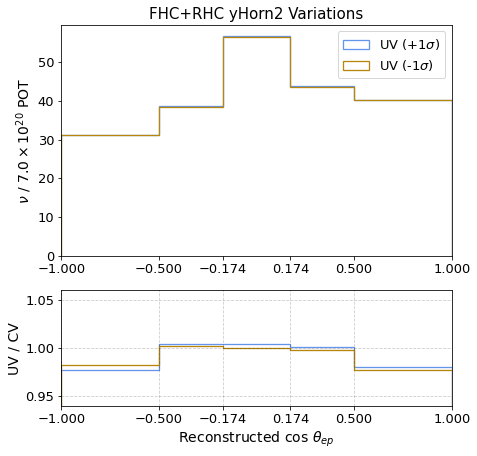

number of universes =  2
number of universes =  2
number of universes =  2
WaterOnHorns


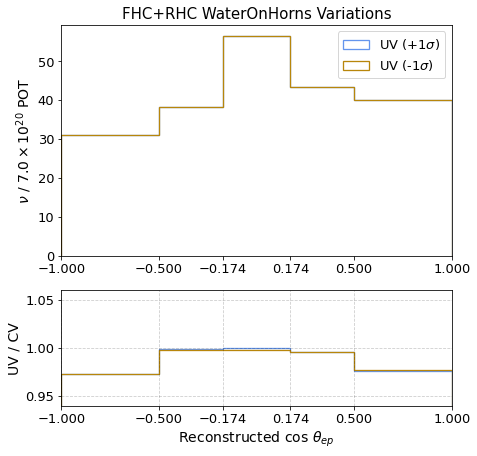

number of universes =  2
number of universes =  2
number of universes =  2
xBeamShift


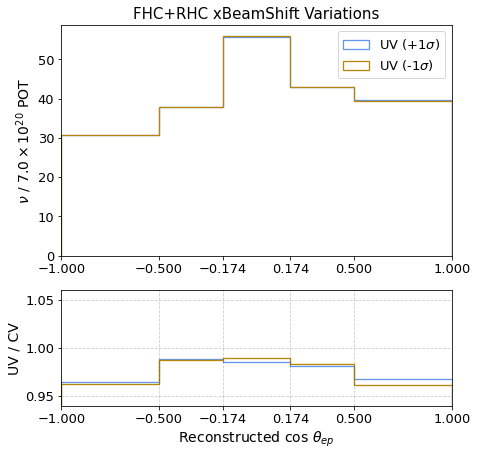

number of universes =  2
number of universes =  2
number of universes =  2
yBeamShift


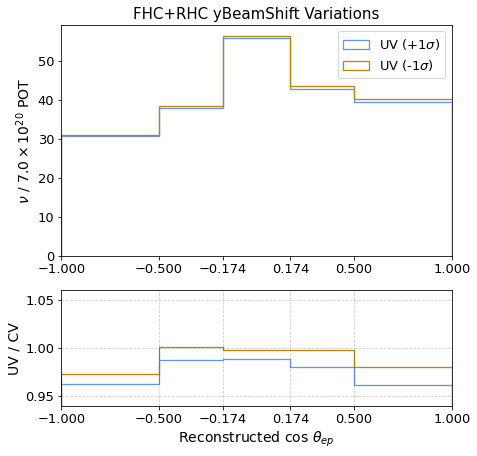

number of universes =  2
number of universes =  2
number of universes =  2
zTargetPosition


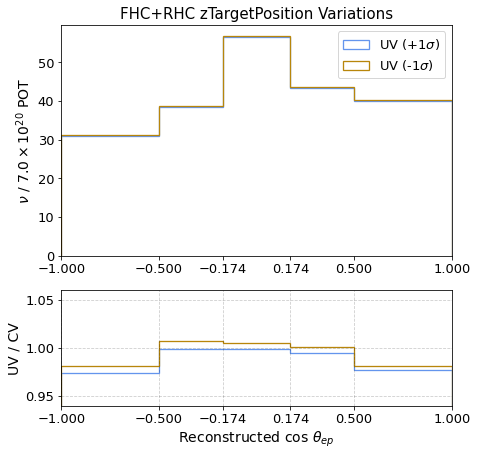

number of universes =  2
number of universes =  2
number of universes =  2


In [20]:
fhc_beamline_unisim_cov = {}
rhc_beamline_unisim_cov = {}
beamline_unisim_cov = {}

i = 0

for v_fhc, v_rhc in zip(fhc_dict['beamline'], rhc_dict['beamline']): 
    
    print(beamline_runs[i])
    
    variations = []
    
    comb_v = [a+b for a,b in zip(v_fhc[0],v_rhc[0])]
    comb_v2 = [a+b for a,b in zip(v_fhc[1],v_rhc[1])]
    
    variations.append(comb_v)
    variations.append(comb_v2)
    
    fig = plt.figure(figsize=(7, 7)) 
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)
    
    #ax1.errorbar(bincenters, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
    #            color='black', label="CV", xerr=binwidth, linestyle='None')

    ax1.hist(bincenters, bins, weights=comb_v, linewidth=1.3, 
        histtype='step', color='cornflowerblue', label='UV (+$1\sigma$)')
    
    ax1.hist(bincenters, bins, weights=comb_v2, linewidth=1.3, 
            histtype='step', color='darkgoldenrod', label='UV (-$1\sigma$)')
    
    # Ratios to CV 
    ax2.hist(bincenters, bins,
             weights=[x/y for x,y in zip(comb_v, [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])])], 
             color="cornflowerblue", histtype='step', linewidth=1.3)
    
    ax2.hist(bincenters, bins,
             weights=[x/y for x,y in zip(comb_v2, [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])])], 
             color="darkgoldenrod", histtype='step', linewidth=1.3)
    
    ax1.set_xlim(xlow, xhigh)
    ax1.set_title("FHC+RHC "+beamline_runs[i]+" Variations", fontsize=15)
    ax1.set_xticks(x_ticks)
    
    ax1.set_ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)
    ax1.legend(fontsize=13)
    
    ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
    ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

    ax2.set_xlabel('Reconstructed '+x_label, fontsize=14)
    ax2.set_ylabel('UV / CV', fontsize=14)
    ax2.set_xlim(xlow, xhigh)
    ax2.set_ylim(0.94, 1.06)
    ax2.set_xticks(x_ticks)
    
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+beamline_runs[i]+"_"+xvar+".pdf", 
    #        transparent=True, bbox_inches='tight')
    
    plt.show()
    
    # compute unisim covariance
    
    fhc_beamline_unisim_cov[beamline_runs[i]] = calcCov(xvar, bins, 
                                                    fhc_ncv_nu, fhc_dict['full_evt_rate'], 
                                                    v_fhc, plot=False)
    
    rhc_beamline_unisim_cov[beamline_runs[i]] = calcCov(xvar, bins, 
                                                    rhc_ncv_nu, rhc_dict['full_evt_rate'], 
                                                    v_rhc, plot=False)
    
    beamline_unisim_cov[beamline_runs[i]] = calcCov(xvar, bins, 
                                                    ncv_nu, 
                                                    [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])], 
                                                    variations, plot=False)
    

    i += 1

In [21]:
for k,d in enumerate([fhc_beamline_unisim_cov, rhc_beamline_unisim_cov, beamline_unisim_cov]): 
    
    cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
    for variation in d.keys(): 

        for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] += d[variation]['cov'][i][j]
                frac_cov[i][j] += d[variation]['frac_cov'][i][j] 


    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
        
    if k==0: 
        
        fhc_beamline_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 
        
        
    elif k==1: 
        rhc_beamline_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 
        
    elif k==2: 
        beamline_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 


In [22]:
rhc_beamline_unisim_dict['fractional_uncertainty']

array([0.0204963 , 0.02001476, 0.02407484, 0.02600748, 0.02689297])

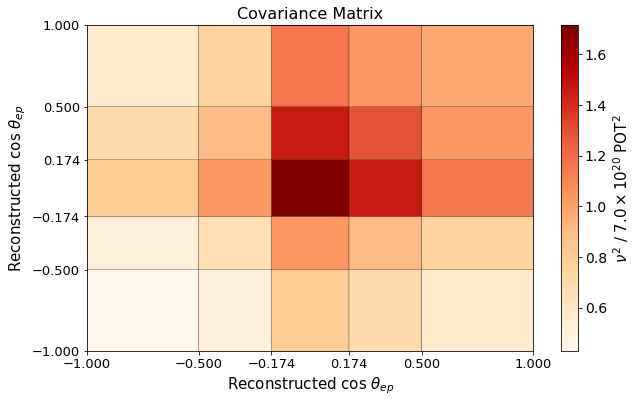

In [23]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, beamline_unisim_dict['cov'], cmap='OrRd', edgecolors='k')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
     
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("Reconstructed "+x_label, fontsize=15)

cbar.set_label(label='$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)

plt.title('Covariance Matrix', fontsize=16)
#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+xvar+"_cov.pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

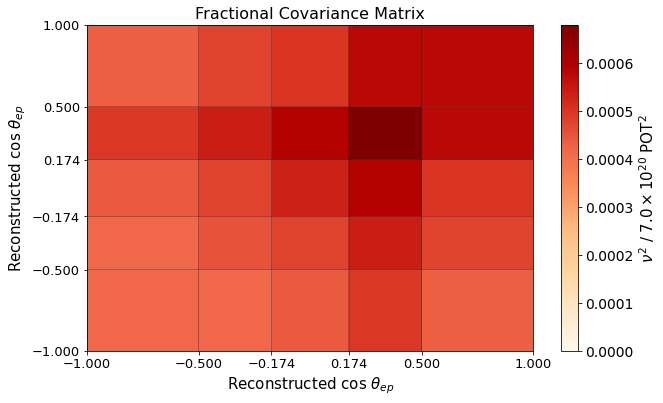

In [24]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, beamline_unisim_dict['frac_cov'], cmap='OrRd', edgecolors='k', vmin=0)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
     
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("Reconstructed "+x_label, fontsize=15)

cbar.set_label(label='$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)

plt.title('Fractional Covariance Matrix', fontsize=16)
#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+xvar+"_frac_cov.pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

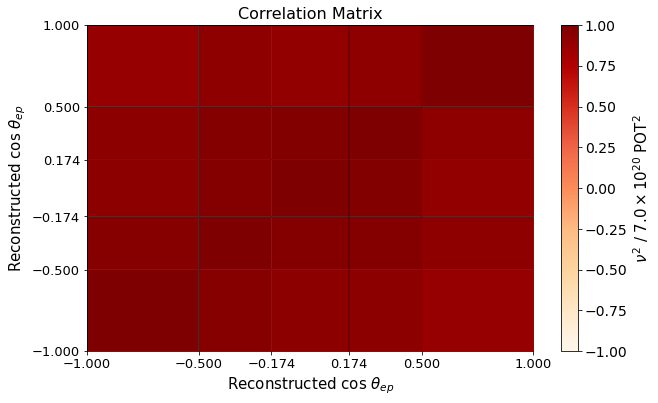

In [25]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, beamline_unisim_dict['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
     
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("Reconstructed "+x_label, fontsize=15)

cbar.set_label(label='$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)

plt.title('Correlation Matrix', fontsize=16)
#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+xvar+"_cor.pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

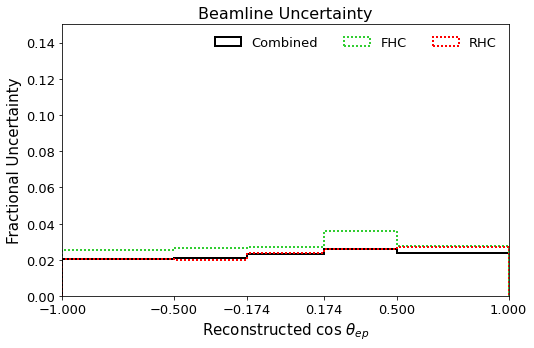

In [26]:
fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=beamline_unisim_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_beamline_unisim_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_beamline_unisim_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.15)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("Beamline Uncertainty", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## GENIE ms

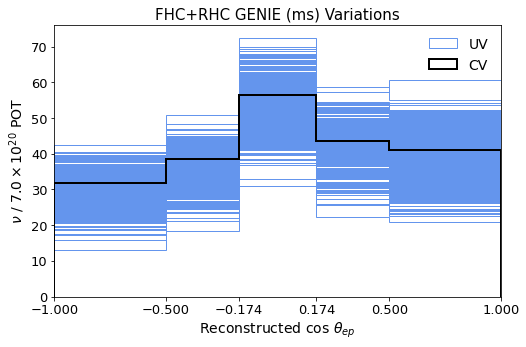

In [27]:
genie_variations = []

fig = plt.figure(figsize=(8, 5)) 

n = 0

for v_fhc, v_rhc in zip(fhc_dict['genie_ms'], rhc_dict['genie_ms']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    genie_variations.append(comb_v)
    
    if n==0: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1, label='UV')
    else: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1)
        
    n+=1

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC GENIE (ms) Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=14, frameon=False)

plt.xlabel('Reconstructed '+x_label, fontsize=14)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [28]:
fhc_genie_dict = calcCov(xvar, bins, fhc_ncv_nu, fhc_dict['full_evt_rate'], 
                    fhc_dict['genie_ms'], plot=False) 

rhc_genie_dict = calcCov(xvar, bins, rhc_ncv_nu, rhc_dict['full_evt_rate'], 
                    rhc_dict['genie_ms'], plot=False) 

number of universes =  500
number of universes =  500


In [29]:
rhc_genie_dict['fractional_uncertainty']

array([0.15726236, 0.14994008, 0.13113838, 0.1422715 , 0.15583897])

number of universes =  500


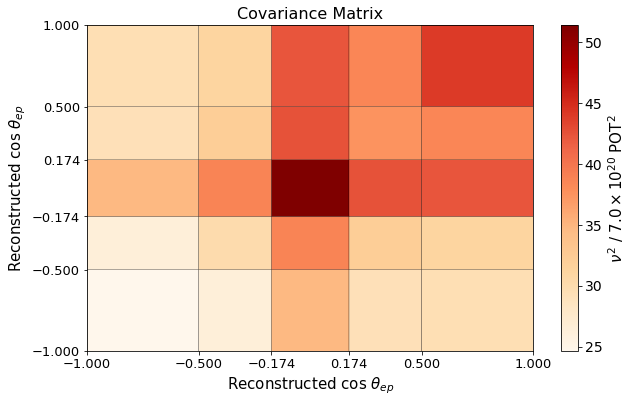

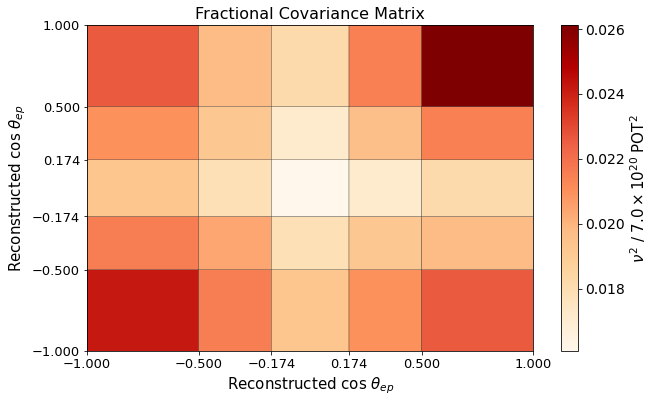

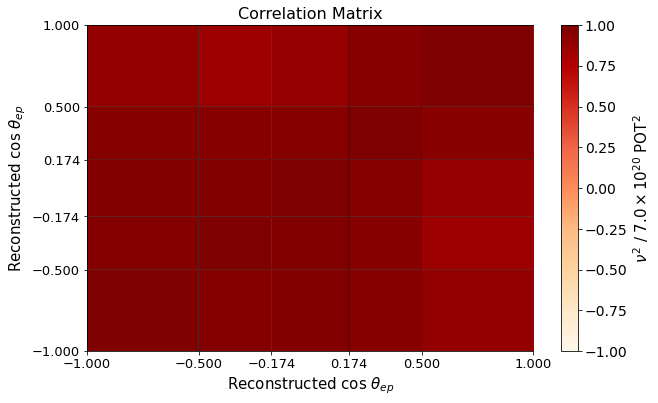

In [30]:
genie_dict = calcCov(xvar, bins, ncv_nu, 
                     [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])], 
                     genie_variations, xticks=x_ticks, xhigh=xhigh,
                     axis_label='Reconstructed '+x_label, pot='$7.0 \\times 10^{20}$ POT',
                     plot=True)#, save="/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_")


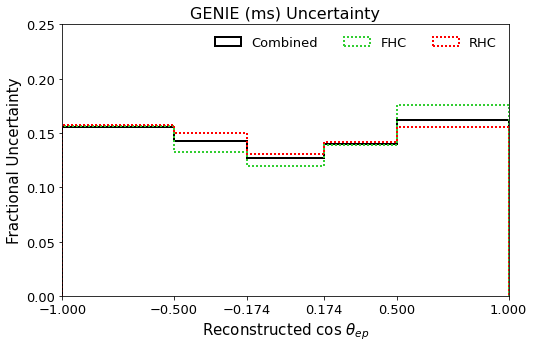

In [31]:
fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=genie_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_genie_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_genie_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.25)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("GENIE (ms) Uncertainty", fontsize=16)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## GENIE us

In [32]:
genie_unisims = ['RPA', 'RPA', 'CCMEC', 'AxFFCCQE', 'VecFFCCQE', 'DecayAngMEC', 'ThetaDelta2Npi', 'ThetaDelta2NRad', 
                          'NormCCCOH', 'NormNCCOH', 'xsr_scc_Fv3', 'xsr_scc_Fa3']

RPA


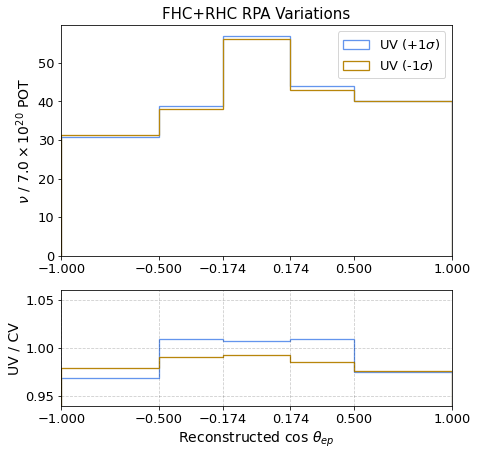

number of universes =  2
number of universes =  2
number of universes =  2
CCMEC


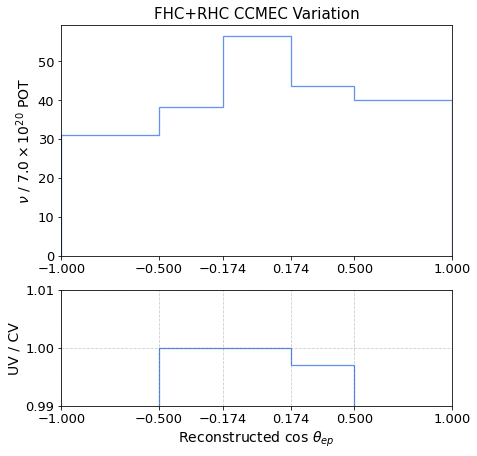

number of universes =  1
number of universes =  1
number of universes =  1
AxFFCCQE


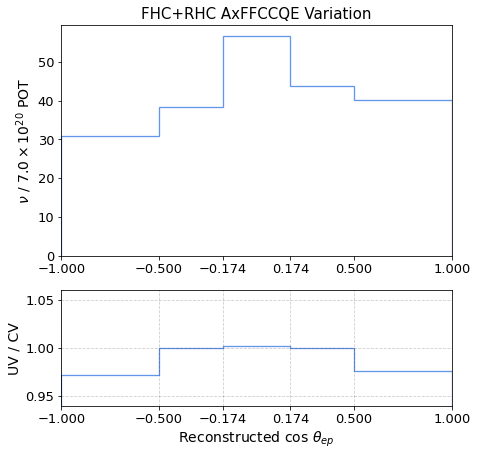

number of universes =  1
number of universes =  1
number of universes =  1
VecFFCCQE


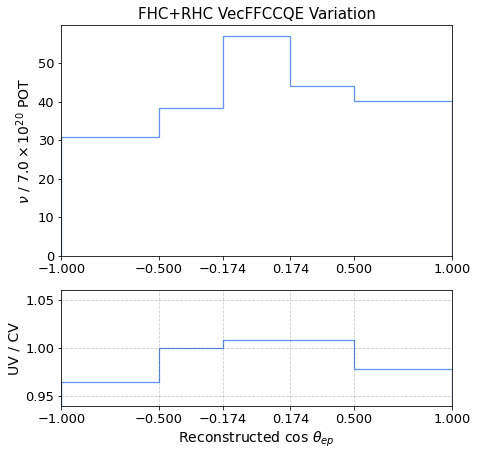

number of universes =  1
number of universes =  1
number of universes =  1
DecayAngMEC


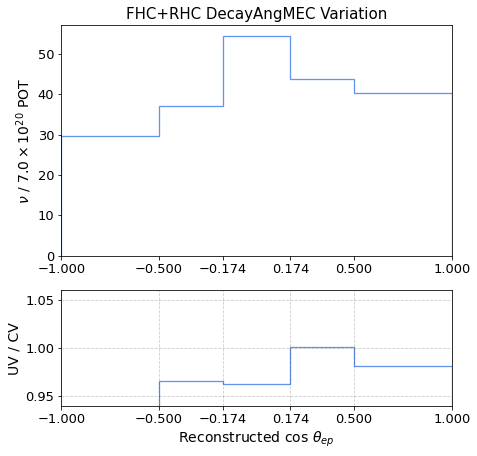

number of universes =  1
number of universes =  1
number of universes =  1
ThetaDelta2Npi


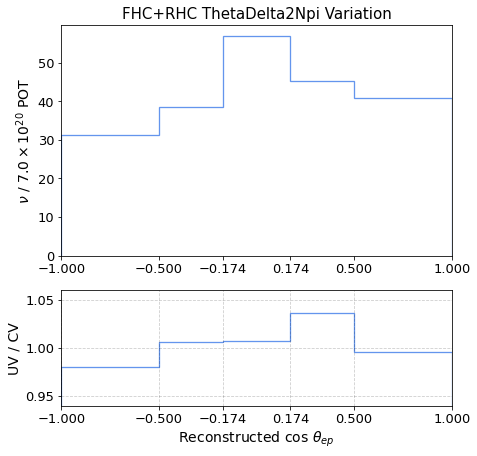

number of universes =  1
number of universes =  1
number of universes =  1
ThetaDelta2NRad


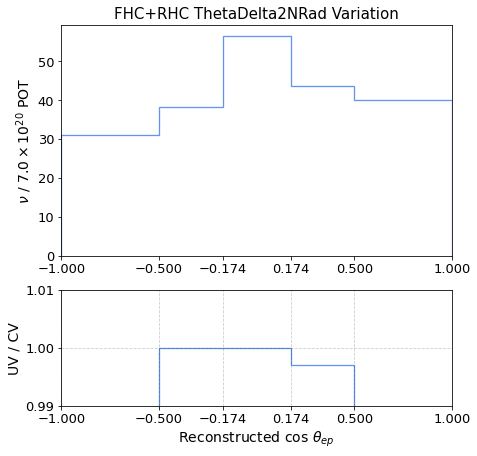

number of universes =  1
number of universes =  1
number of universes =  1
NormCCCOH


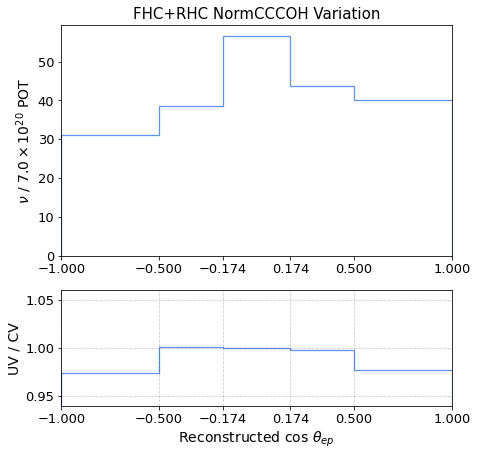

number of universes =  1
number of universes =  1
number of universes =  1
NormNCCOH


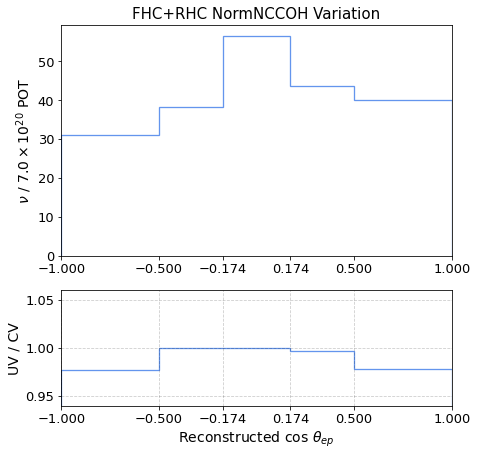

number of universes =  1
number of universes =  1
number of universes =  1
xsr_scc_Fv3


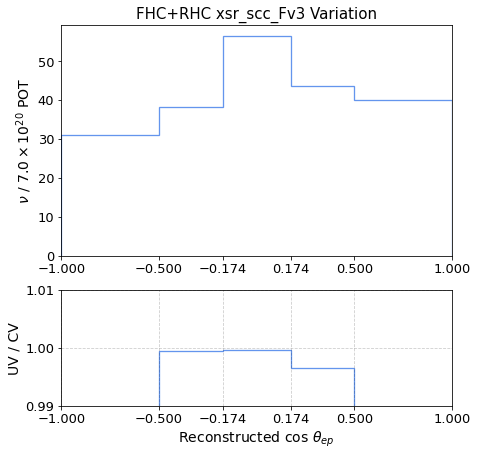

number of universes =  1
number of universes =  1
number of universes =  1
xsr_scc_Fa3


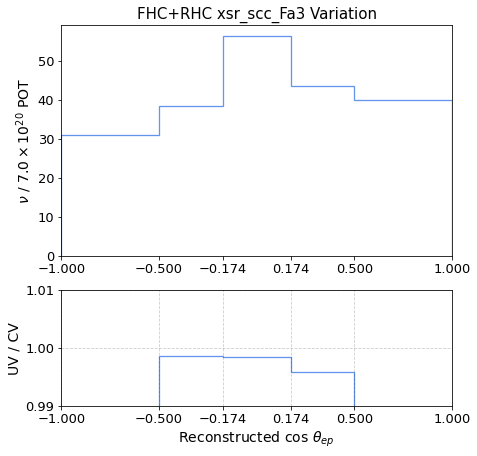

number of universes =  1
number of universes =  1
number of universes =  1


In [33]:
genie_unisim_cov = {}
fhc_genie_unisim_cov = {}
rhc_genie_unisim_cov = {}


i = 1

for v_fhc, v_rhc in zip(fhc_dict['genie_us'], rhc_dict['genie_us']): 
    
    print(genie_unisims[i])
    
    variations = []
    
    comb_v = [a+b for a,b in zip(v_fhc[0],v_rhc[0])]
    
    if i==1:
        comb_v2 = [a+b for a,b in zip(v_fhc[1],v_rhc[1])]
        variations.append(comb_v)
        variations.append(comb_v2)
    
    else: 
        variations.append(comb_v)
    
    fig = plt.figure(figsize=(7, 7)) 
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    ax1.tick_params(axis = 'x', which = 'major', labelsize = 13)
    ax2.tick_params(axis = 'x', which = 'major', labelsize = 13)
    
    ax1.tick_params(axis = 'y', which = 'major', labelsize = 13)
    ax2.tick_params(axis = 'y', which = 'major', labelsize = 13)
    
    #ax1.errorbar(bincenters, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
    #            color='black', label="CV", xerr=binwidth, linestyle='None')
    
    if i==1: 
        
        ax1.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v, linewidth=1.3, 
        histtype='step', color='cornflowerblue', label='UV (+1$\\sigma$)')
        
        ax1.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v2, linewidth=1.3, 
        histtype='step', color='darkgoldenrod', label='UV (-1$\\sigma$)')
        
        ax1.legend(fontsize=13)
        
    else: 
        ax1.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v, linewidth=1.3, 
        histtype='step', color='cornflowerblue')
    
    # Ratios to CV 
    ax2.hist(bincenters, bins,
             weights=[x/y for x,y in zip(comb_v, [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])])], 
             color="cornflowerblue", histtype='step', linewidth=1.3)
    
    #print([x/y for x,y in zip(comb_v, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])])])
    
    if i==1: 
        ax2.hist(bincenters, bins,
             weights=[x/y for x,y in zip(comb_v2, [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])])], 
             color="darkgoldenrod", histtype='step', linewidth=1.3)
    
    
    ax1.set_xlim(xlow, xhigh)
    if i==1: 
        ax1.set_title("FHC+RHC "+genie_unisims[i]+" Variations", fontsize=15)
    else: 
        ax1.set_title("FHC+RHC "+genie_unisims[i]+" Variation", fontsize=15)
    ax1.set_xticks(x_ticks)
    
    ax1.set_ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)
    
    ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
    ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

    ax2.set_xlabel('Reconstructed '+x_label, fontsize=14)
    ax2.set_ylabel('UV / CV', fontsize=14)
    ax2.set_xlim(xlow, xhigh)
    
    if (genie_unisims[i] == 'CCMEC') or (genie_unisims[i] =='ThetaDelta2NRad') or ('xsr' in genie_unisims[i]): 
        ax2.set_ylim(0.99, 1.01)
    else: 
        ax2.set_ylim(0.94, 1.06)
    
    ax2.set_xticks(x_ticks)
    
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+genie_unisims[i]+"_"+xvar+".pdf", 
    #        transparent=True, bbox_inches='tight')
    
    plt.show()
    
    fhc_genie_unisim_cov[genie_unisims[i]] = calcCov(xvar, bins, 
                                                    fhc_ncv_nu, fhc_dict['full_evt_rate'], 
                                                    v_fhc, plot=False, save=False)
    
    rhc_genie_unisim_cov[genie_unisims[i]] = calcCov(xvar, bins, 
                                                    rhc_ncv_nu, rhc_dict['full_evt_rate'], 
                                                    v_rhc, plot=False, save=False)
    
    genie_unisim_cov[genie_unisims[i]] = calcCov(xvar, bins, ncv_nu, 
                                     [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])], 
                                     variations, plot=False, save=False)
    

    i += 1

In [34]:
for k,d in enumerate([fhc_genie_unisim_cov, rhc_genie_unisim_cov, genie_unisim_cov]): 
    
    cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
    for variation in d.keys(): 

        for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] += d[variation]['cov'][i][j]
                frac_cov[i][j] += d[variation]['frac_cov'][i][j] 


    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
        
    if k==0: 
        fhc_genie_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 
        
        
    elif k==1: 
        rhc_genie_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 
        
    elif k==2: 
        genie_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 


In [35]:
rhc_genie_unisim_dict['fractional_uncertainty']

array([0.07248221, 0.03245839, 0.04756809, 0.04649271, 0.02430487])

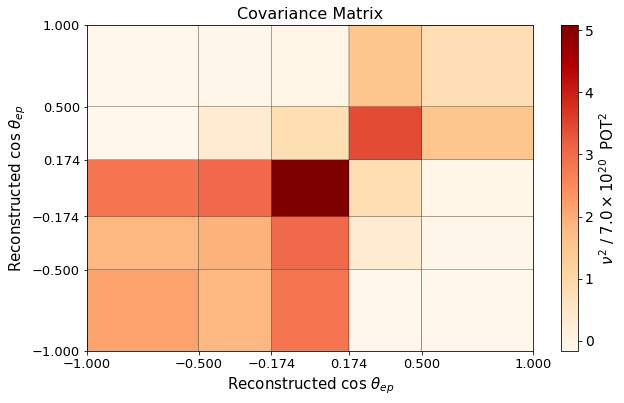

In [36]:
# covariance

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, genie_unisim_dict['cov'], cmap='OrRd', edgecolors='k')
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)
        
plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xlabel('Reconstructed '+x_label, fontsize=15)
plt.ylabel('Reconstructed '+x_label, fontsize=15)

plt.title('Covariance Matrix', fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+xvar+"_cov.pdf", 
#            transparent=True, bbox_inches='tight')


plt.show()

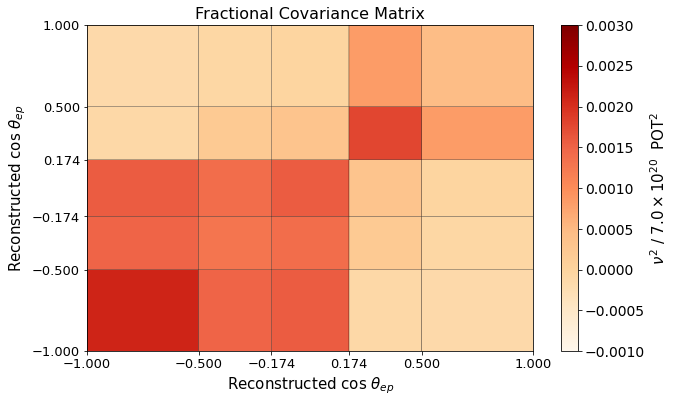

In [37]:
# frac covariance

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, genie_unisim_dict['frac_cov'], cmap='OrRd', edgecolors='k', vmin=-0.001, vmax=0.003)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)
        
plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xlabel('Reconstructed '+x_label, fontsize=15)
plt.ylabel('Reconstructed '+x_label, fontsize=15)

plt.title('Fractional Covariance Matrix', fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+xvar+"_frac_cov.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

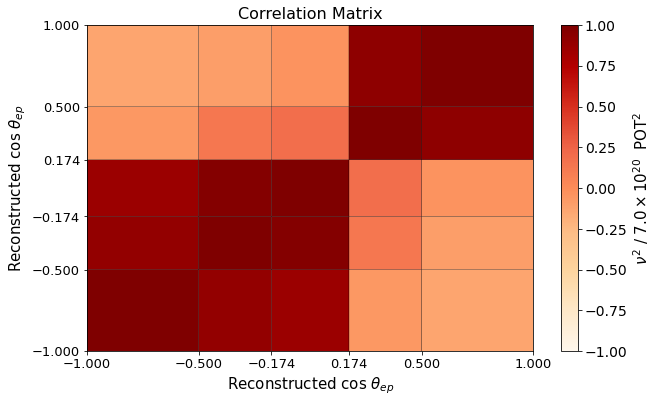

In [38]:
# correlation

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, genie_unisim_dict['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)
        
plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xlabel('Reconstructed '+x_label, fontsize=15)
plt.ylabel('Reconstructed '+x_label, fontsize=15)

plt.title('Correlation Matrix', fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+xvar+"_cor.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

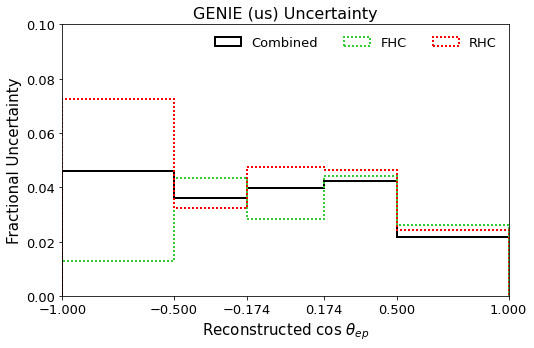

In [39]:


fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=genie_unisim_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_genie_unisim_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_genie_unisim_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.1)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("GENIE (us) Uncertainty", fontsize=16)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## GEANT4

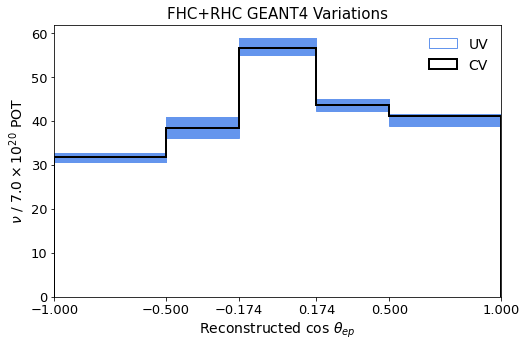

In [40]:
geant4_variations = []

fig = plt.figure(figsize=(8, 5)) 

n = 0

for v_fhc, v_rhc in zip(fhc_dict['geant4'], rhc_dict['geant4']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    geant4_variations.append(comb_v)
    
    if n==0: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1, label='UV')
    else: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1)
        
    
    n+=1

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC GEANT4 Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=14, frameon=False)

plt.xlabel('Reconstructed '+x_label, fontsize=14)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/geant4_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()


In [41]:
fhc_geant4_dict = calcCov(xvar, bins, fhc_ncv_nu, fhc_dict['full_evt_rate'], 
                    fhc_dict['geant4'], plot=False) 

rhc_geant4_dict = calcCov(xvar, bins, rhc_ncv_nu, rhc_dict['full_evt_rate'], 
                    rhc_dict['geant4'], plot=False) 

number of universes =  1000
number of universes =  1000


number of universes =  1000


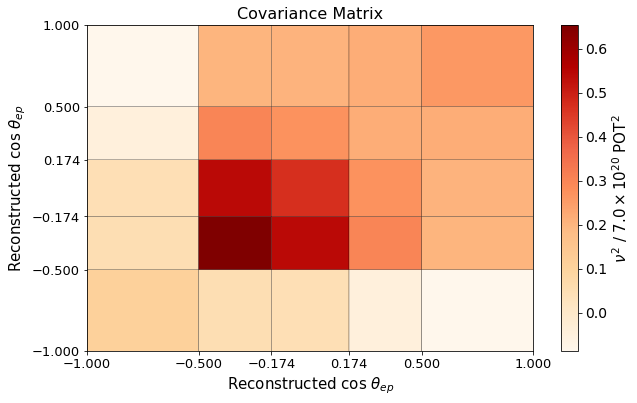

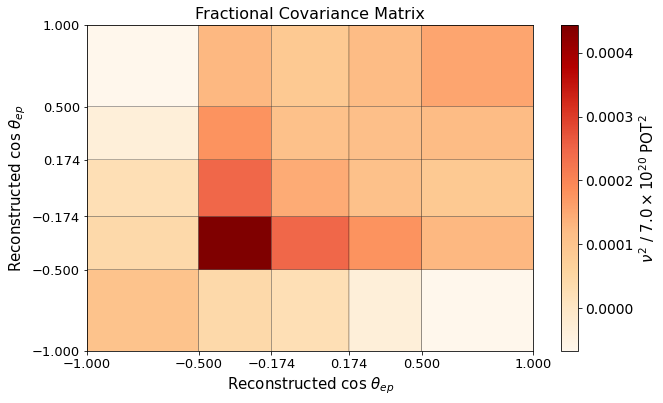

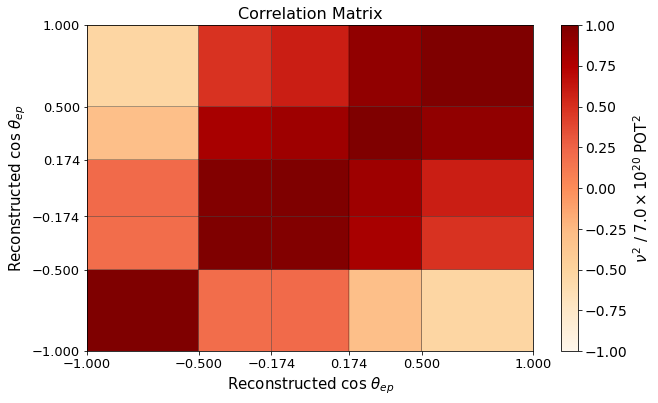

In [42]:
geant4_dict = calcCov(xvar, bins, ncv_nu, 
                    [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])], 
                    geant4_variations, plot=True, xticks=x_ticks, xhigh=xhigh, axis_label="Reconstructed "+x_label, 
                     pot='$7.0 \\times 10^{20}$ POT')
                    #save="/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/geant4_") 

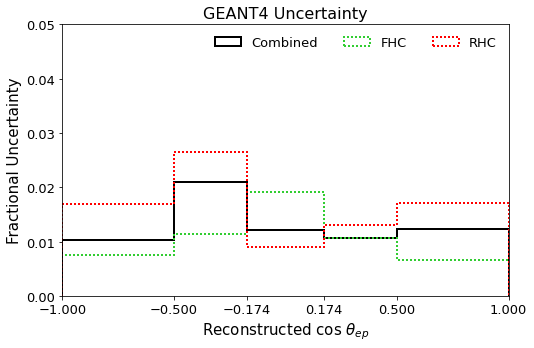

In [43]:


fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=geant4_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_geant4_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_geant4_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.05)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("GEANT4 Uncertainty", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/geant4_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [44]:
rhc_geant4_dict['fractional_uncertainty']

array([0.01690775, 0.02660133, 0.00907312, 0.01312045, 0.01717832])

## MC+EXT Stat uncertainty (number of events)

In [45]:
stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

fhc_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
rhc_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

fhc_stat_percent_error = []
rhc_stat_percent_error = []
stat_percent_error = []

In [46]:
mc_signal_sumw2 = [a+b for a,b in zip(fhc_dict['mc_signal_sumw2'], rhc_dict['mc_signal_sumw2'])]
mc_bkgd_sumw2 = [a+b for a,b in zip(fhc_dict['mc_bkgd_sumw2'], rhc_dict['mc_bkgd_sumw2'])]
ext_sumw2 = [a+b for a,b in zip(fhc_dict['ext_sumw2'], rhc_dict['ext_sumw2'])]
full_evt_rate = [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])]


In [47]:
full_evt_rate

[31.881640174060877,
 38.40258902078702,
 56.57301568092423,
 43.70998002342181,
 41.069212724582165]

In [48]:
for i in range(len(bins)-1):

    stat_cov[i][i] = (mc_signal_sumw2[i] + mc_bkgd_sumw2[i] + ext_sumw2[i])

    frac_stat_cov[i][i] = stat_cov[i][i] / (full_evt_rate[i]**2)

                # this is OK -- just take the sum of the weights squared of the full event rate for GENIE closure test 
    fhc_frac_stat_cov[i][i] = ( fhc_dict['mc_signal_sumw2'][i] + fhc_dict['mc_bkgd_sumw2'][i] + fhc_dict['ext_sumw2'][i]) / (fhc_dict['full_evt_rate'][i]**2)
    rhc_frac_stat_cov[i][i] = ( rhc_dict['mc_signal_sumw2'][i] + rhc_dict['mc_bkgd_sumw2'][i] + rhc_dict['ext_sumw2'][i]) / (rhc_dict['full_evt_rate'][i]**2)

    fhc_stat_percent_error.append( np.sqrt( fhc_frac_stat_cov[i][i]) ) 
    rhc_stat_percent_error.append(np.sqrt(rhc_frac_stat_cov[i][i])) 
    stat_percent_error.append(np.sqrt(frac_stat_cov[i][i])) 
        

    

In [49]:
#nuwro_full_sumw2 = fhc_dict['nuwro_full_sumw2']
#for i in range(len(bins)-1):
#    fhc_frac_stat_cov[i][i] = (nuwro_full_sumw2[i] + fhc_dict['mc_bkgd_sumw2'][i] + fhc_dict['ext_sumw2'][i]) / (fhc_dict['evt_rate_nuwro_ppfx'][i]**2)
#    fhc_stat_percent_error.append( np.sqrt( fhc_frac_stat_cov[i][i]) ) 



In [50]:
len(bincenters)

5

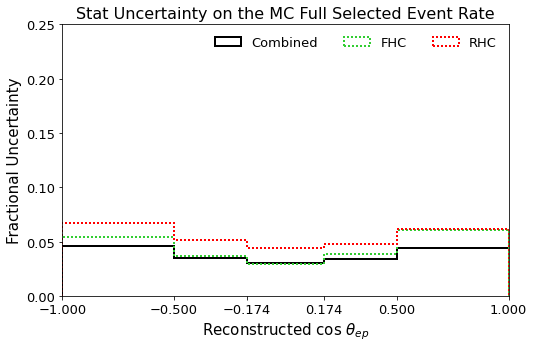

In [51]:


fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=stat_percent_error, color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_stat_percent_error, 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_stat_percent_error, 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, .25)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("Stat Uncertainty on the MC Full Selected Event Rate", fontsize=16)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/stat_evt_count_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()


In [52]:
rhc_stat_percent_error

[0.06759588933762926,
 0.051365895579933415,
 0.04407718893080056,
 0.04824016530048769,
 0.06188818897535561]

## Beam-on Stat Uncertainty

In [53]:
beamon_fhc_stat_percent_error = []
beamon_rhc_stat_percent_error = []
beamon_stat_percent_error = []

fhc_beamon_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
rhc_beamon_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
beamon_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

In [54]:
# need to use the full event rates - before background subtraction
total_beamon_counts = [a+b for a,b in zip(fhc_dict['beamon_full_evt_rate'],rhc_dict['beamon_full_evt_rate'])] 

    
for i in range(len(bins)-1):
    
    beamon_fhc_stat_percent_error.append( np.sqrt( fhc_dict['beamon_full_evt_rate'][i])/fhc_dict['beamon_full_evt_rate'][i] ) 
    beamon_rhc_stat_percent_error.append(np.sqrt(rhc_dict['beamon_full_evt_rate'][i])/rhc_dict['beamon_full_evt_rate'][i]) 
    beamon_stat_percent_error.append(np.sqrt(total_beamon_counts[i])/total_beamon_counts[i])
    
for i in range(len(bins)-1):
    fhc_beamon_frac_stat_cov[i][i] = beamon_fhc_stat_percent_error[i]**2
    rhc_beamon_frac_stat_cov[i][i] = beamon_rhc_stat_percent_error[i]**2
    beamon_frac_stat_cov[i][i] = beamon_stat_percent_error[i]**2


## Dirt Uncertainty 

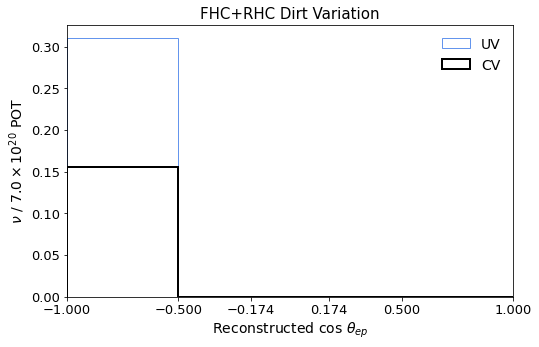

In [55]:
dirt_variations = []

fig = plt.figure(figsize=(8, 5)) 


comb_v = [a+b for a,b in zip(fhc_dict['dirt'],rhc_dict['dirt'])]
dirt_variations.append(comb_v)
    
plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
        histtype='step', color='cornflowerblue', linewidth=1, label='UV')

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['cv_dirt'], rhc_dict['cv_dirt'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC Dirt Variation", fontsize=15)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

plt.legend(fontsize=14, frameon=False)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Reconstructed '+x_label, fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/dirt_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

In [56]:
fhc_dirt_dict = dirt_unisim(xvar, bins, fhc_dict['full_evt_rate'], fhc_dict['cv_dirt'], 1.0, isrun3=False, plot=False, 
                               x_label=None, title=None)



number of universes =  1


In [57]:
rhc_dirt_dict = dirt_unisim(xvar, bins, rhc_dict['full_evt_rate'], rhc_dict['cv_dirt'], 1.0, isrun3=True, plot=False, 
                               x_label=None, title=None)

number of universes =  1


In [58]:
dirt_dict = dirt_unisim(xvar, bins, [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])], 
                        [a+b for a,b in zip(fhc_dict['cv_dirt'], rhc_dict['cv_dirt'])], 
                        1.0, plot=False, x_label=None, title=None)

number of universes =  1


In [59]:
fhc_dirt_dict['fractional_uncertainty']

array([0.01243532, 0.        , 0.        , 0.        , 0.        ])

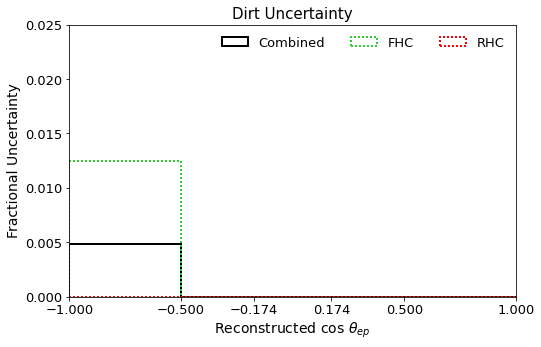

In [60]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=dirt_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_dirt_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_dirt_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xlim(xlow, xhigh)
plt.ylim(0, 0.025)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("Dirt Uncertainty", fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/dirt_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## POT counting 

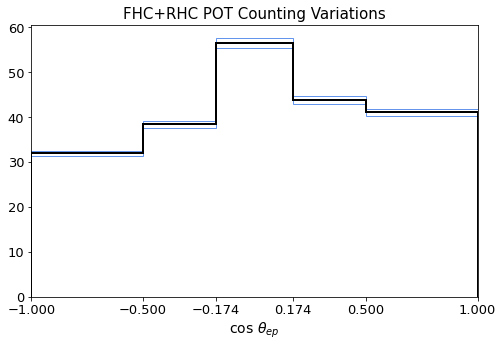

In [61]:
pot_variations = []

fig = plt.figure(figsize=(8, 5)) 

for v_fhc, v_rhc in zip(fhc_dict['pot_counting'], rhc_dict['pot_counting']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    pot_variations.append(comb_v)
    
    plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
        histtype='step', color='cornflowerblue', linewidth=1)

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])],
        histtype='step', color='black', linewidth=2) 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC POT Counting Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)
plt.show()

# Full Uncertainty 

In [62]:
xvar

'tksh_angle'

### FHC only 

In [63]:
fhc_frac_cov_dict = {
    'ppfx' : fhc_ppfx_dict['frac_cov'], 
    'beamline' : fhc_beamline_unisim_dict['frac_cov'], 
    'genie_ms' : fhc_genie_dict['frac_cov'], 
    'genie_us': fhc_genie_unisim_dict['frac_cov'], 
    'geant4' : fhc_geant4_dict['frac_cov'],
    'detector' :  [ [0]*(len(bins)-1) for x in range(len(bins)-1) ], 
    'pot_counting' : [ [round(0.02**2, 5)]*(len(bins)-1) for x in range(len(bins)-1) ], 
    'dirt' : fhc_dirt_dict['frac_cov'],
    'stat' : fhc_frac_stat_cov
}

for i in range(len(bins)-1): 
    fhc_frac_cov_dict['detector'][i][i] = parameters(ISRUN3=False)['detsys_flat']**2


Note: Input must be fractional covariance matrices !


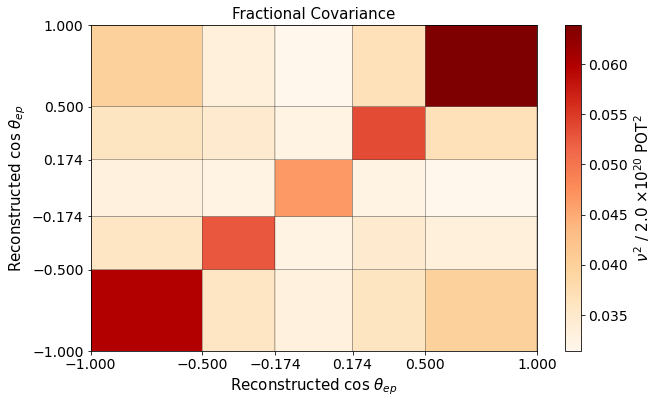

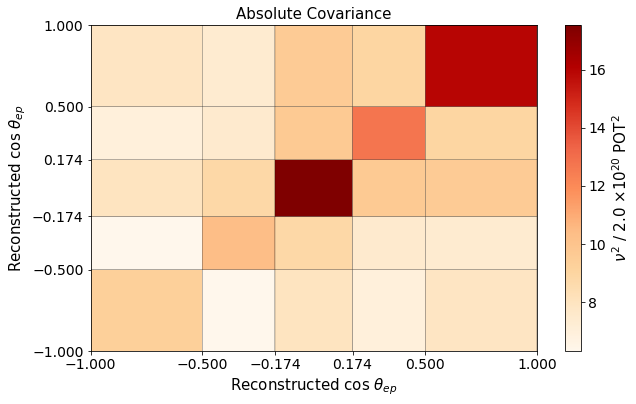

In [64]:
fhc_tot_frac_cov, fhc_tot_abs_cov = plotFullCov(fhc_frac_cov_dict, xvar, fhc_dict['full_evt_rate'], 
                                                bins, xlow, xhigh, x_ticks=x_ticks, 
                                                axis_label='Reconstructed '+x_label, pot="2.0 $\\times 10^{20}$ POT")


In [65]:
# add genie in quadrature
fhc_frac_cov_dict['genie_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(fhc_frac_cov_dict['genie_ms'], fhc_frac_cov_dict['genie_us'])]

# add ppfx & beamline geometry in quadrature
fhc_frac_cov_dict['flux_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(fhc_frac_cov_dict['ppfx'], fhc_frac_cov_dict['beamline'])]


In [66]:
fhc_frac_cov_dict.keys()

dict_keys(['ppfx', 'beamline', 'genie_ms', 'genie_us', 'geant4', 'detector', 'pot_counting', 'dirt', 'stat', 'genie_all', 'flux_all'])

In [67]:
fhc_frac_unc_dict = {
        'flux_all' : np.sqrt(np.diagonal(fhc_frac_cov_dict['flux_all'])), 
        'genie_all' : np.sqrt(np.diagonal(fhc_frac_cov_dict['genie_all'])), 
        'geant4' : np.sqrt(np.diagonal(fhc_frac_cov_dict['geant4'])),
        'detector' : np.sqrt(np.diagonal(fhc_frac_cov_dict['detector'])), 
        'pot_counting' : np.sqrt(np.diagonal(fhc_frac_cov_dict['pot_counting'])), 
        'dirt' : np.sqrt(np.diagonal(fhc_frac_cov_dict['dirt'])),
        'stat' : np.sqrt(np.diagonal(fhc_frac_cov_dict['stat'])), 
        'total' : np.sqrt(np.diagonal(fhc_tot_frac_cov))
}

In [68]:
fhc_frac_unc_dict['total']

array([0.2447807 , 0.22942373, 0.21569354, 0.23168197, 0.25275153])

In [69]:
np.sqrt(np.diag(fhc_tot_frac_cov))

array([0.2447807 , 0.22942373, 0.21569354, 0.23168197, 0.25275153])

### RHC only 

In [70]:
rhc_frac_cov_dict = {
    'ppfx' : rhc_ppfx_dict['frac_cov'], 
    'beamline' : rhc_beamline_unisim_dict['frac_cov'], 
    'genie_ms' : rhc_genie_dict['frac_cov'], 
    'genie_us': rhc_genie_unisim_dict['frac_cov'], 
    'geant4' : rhc_geant4_dict['frac_cov'],
    'detector' :  [ [0]*(len(bins)-1) for x in range(len(bins)-1) ], 
    'pot_counting' : [ [round(0.02**2, 5)]*(len(bins)-1) for x in range(len(bins)-1) ], 
    'dirt' : rhc_dirt_dict['frac_cov'],
    'stat' : rhc_frac_stat_cov
}

for i in range(len(bins)-1): 
    rhc_frac_cov_dict['detector'][i][i] = parameters(ISRUN3=False)['detsys_flat']**2


Note: Input must be fractional covariance matrices !


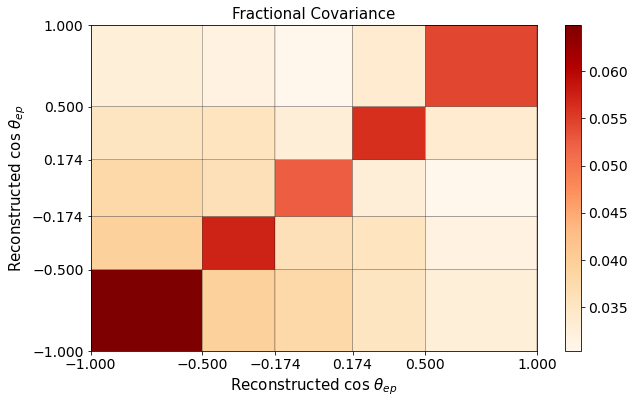

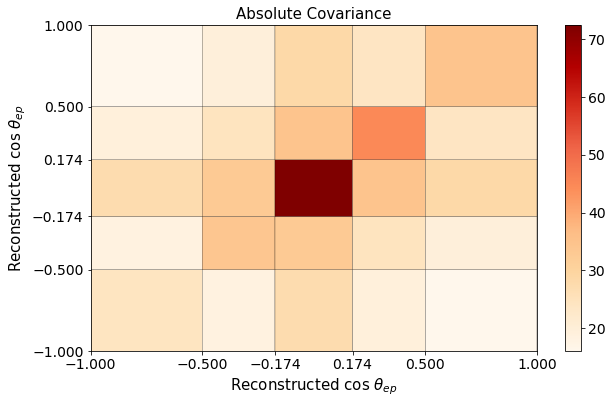

In [71]:
#if isClosureTest: 
    #print("calculating genie covariance....")
rhc_tot_frac_cov, rhc_tot_abs_cov = plotFullCov(rhc_frac_cov_dict, xvar, rhc_dict['full_evt_rate'], 
                                                bins, xlow, xhigh, x_ticks=x_ticks, save=False, 
                                                axis_label='Reconstructed '+x_label)
    

In [72]:
# add genie in quadrature
rhc_frac_cov_dict['genie_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(rhc_frac_cov_dict['genie_ms'], rhc_frac_cov_dict['genie_us'])]

# add ppfx & beamline geometry in quadrature
rhc_frac_cov_dict['flux_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(rhc_frac_cov_dict['ppfx'], rhc_frac_cov_dict['beamline'])]


In [73]:
rhc_frac_unc_dict = {
        'flux_all' : np.sqrt(np.diagonal(rhc_frac_cov_dict['flux_all'])), 
        'genie_all' : np.sqrt(np.diagonal(rhc_frac_cov_dict['genie_all'])), 
        'geant4' : np.sqrt(np.diagonal(rhc_frac_cov_dict['geant4'])),
        'detector' : np.sqrt(np.diagonal(rhc_frac_cov_dict['detector'])), 
        'pot_counting' : np.sqrt(np.diagonal(rhc_frac_cov_dict['pot_counting'])), 
        'dirt' : np.sqrt(np.diagonal(rhc_frac_cov_dict['dirt'])),
        'stat' : np.sqrt(np.diagonal(rhc_frac_cov_dict['stat'])), 
        'total' : np.sqrt(np.diagonal(rhc_tot_frac_cov))
}

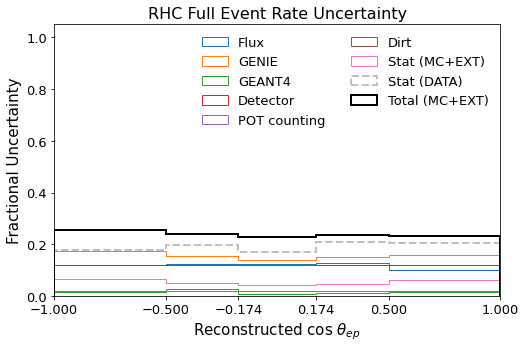

In [74]:
fig = plt.figure(figsize=(8, 5))  



# FLUX
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Flux", 
             weights=rhc_frac_unc_dict['flux_all'])#, color='royalblue')

# CROSS SECTION MODELS 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE", 
             weights=rhc_frac_unc_dict['genie_all'])#, color='goldenrod')

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GEANT4", 
             weights=rhc_frac_unc_dict['geant4'])#, color='green')

# DETECTOR 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Detector", 
             weights=rhc_frac_unc_dict['detector'])#, color='crimson')

# POT COUNTING 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="POT counting",
            weights=rhc_frac_unc_dict['pot_counting'])#, color='purple')

# DIRT 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Dirt",
            weights=rhc_frac_unc_dict['dirt'])#, color='brown')

# STATISTICAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat (MC+EXT)",
            weights=rhc_frac_unc_dict['stat'])#, color='hotpink')

# beam on 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat (DATA)",
            weights=beamon_rhc_stat_percent_error, color='silver', linewidth=2, linestyle="dashed")

# TOTAL 
plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(rhc_tot_frac_cov)), color='black', 
            linewidth=2, label='Total (MC+EXT)')


plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 1.05)

plt.legend(fontsize=13, frameon=False, ncol=2)
plt.title("RHC Full Event Rate Uncertainty", fontsize=16)
plt.show()

In [75]:
rhc_frac_unc_dict['flux_all']

array([0.12132491, 0.12307783, 0.12526555, 0.12707854, 0.10040203])

### FHC + RHC  

In [76]:
frac_cov_dict = {
    'ppfx' : ppfx_dict['frac_cov'], 
    'beamline' : beamline_unisim_dict['frac_cov'], 
    'genie_ms' : genie_dict['frac_cov'], 
    'genie_us': genie_unisim_dict['frac_cov'], 
    'geant4' : geant4_dict['frac_cov'],
    'detector' :  [ [0]*(len(bins)-1) for x in range(len(bins)-1) ], 
    'pot_counting' : [ [round(0.02**2, 5)]*(len(bins)-1) for x in range(len(bins)-1) ], 
    'dirt' : dirt_dict['frac_cov'],
    'stat' : frac_stat_cov
}

for i in range(len(bins)-1): 
    frac_cov_dict['detector'][i][i] = parameters(ISRUN3=False)['detsys_flat']**2



Note: Input must be fractional covariance matrices !


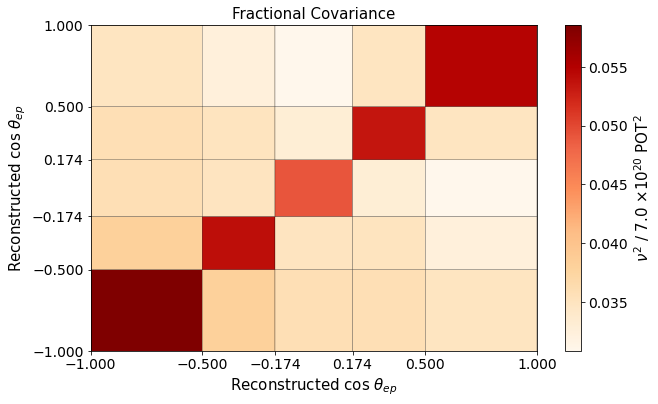

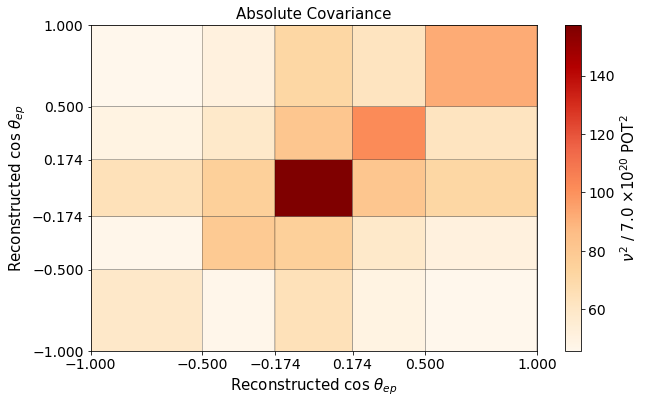

In [77]:
#if isClosureTest: 
#    print("calculating genie covariance....")
tot_frac_cov, tot_abs_cov = plotFullCov(frac_cov_dict, xvar, full_evt_rate, bins, xlow, xhigh, x_ticks=x_ticks,
                      axis_label='Reconstructed '+x_label, pot="7.0 $\\times 10^{20}$ POT")
                                       #save='/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/')


In [78]:
frac_cov_dict['flux_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['ppfx'], frac_cov_dict['beamline'])]


In [79]:
# add genie in quadrature
frac_cov_dict['genie_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['genie_ms'], frac_cov_dict['genie_us'])]


In [80]:
# clean away nans
v = np.array(tot_frac_cov)
v[np.isnan(v)] = 0
tot_frac_cov = v

In [81]:
frac_unc_dict = {
        'flux_all' : np.sqrt(np.diagonal(frac_cov_dict['flux_all'])), 
        'genie_all' : np.sqrt(np.diagonal(frac_cov_dict['genie_all'])), 
        'geant4' : np.sqrt(np.diagonal(frac_cov_dict['geant4'])),
        'detector' : np.sqrt(np.diagonal(frac_cov_dict['detector'])), 
        'pot_counting' : np.sqrt(np.diagonal(frac_cov_dict['pot_counting'])), 
        'dirt' : np.sqrt(np.diagonal(frac_cov_dict['dirt'])),
        'stat' : np.sqrt(np.diagonal(frac_cov_dict['stat'])), 
        'total' : np.sqrt(np.diagonal(tot_frac_cov))
}

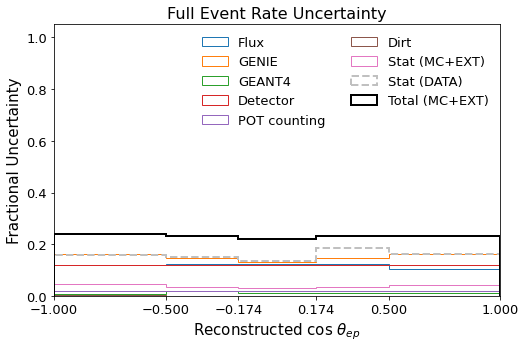

In [82]:
fig = plt.figure(figsize=(8, 5))  



# FLUX
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Flux", 
             weights=frac_unc_dict['flux_all'])#, color='royalblue')

# CROSS SECTION MODELS 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE", 
             weights=frac_unc_dict['genie_all'])#, color='goldenrod')

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GEANT4", 
             weights=frac_unc_dict['geant4'])#, color='green')

# DETECTOR 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Detector", 
             weights=frac_unc_dict['detector'])#, color='crimson')

# POT COUNTING 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="POT counting",
            weights=frac_unc_dict['pot_counting'])#, color='purple')

# DIRT 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Dirt",
            weights=frac_unc_dict['dirt'])#, color='brown')

# STATISTICAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat (MC+EXT)",
            weights=frac_unc_dict['stat'])#, color='hotpink')

# beam on 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat (DATA)",
            weights=beamon_stat_percent_error, color='silver', linewidth=2, linestyle="dashed")

# TOTAL 
plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(tot_frac_cov)), color='black', 
            linewidth=2, label='Total (MC+EXT)')


plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 1.05)

plt.legend(fontsize=13, frameon=False, ncol=2)
plt.title("Full Event Rate Uncertainty", fontsize=16)
plt.show()

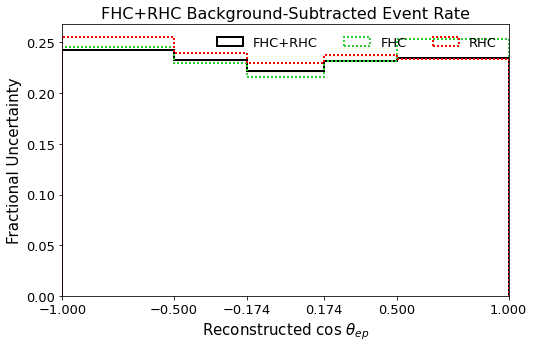

In [83]:

fig = plt.figure(figsize=(8, 5))  

# TOTAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC+RHC",
        weights=frac_unc_dict['total'], linewidth=2, color='black')

# FHC

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=np.sqrt(np.diag(fhc_tot_frac_cov)), 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')

# RHC
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=np.sqrt(np.diag(rhc_tot_frac_cov)), 
         linestyle=(0, (1, 1)), color='red', linewidth=2)


plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
#plt.ylim(0, 4.5)

plt.legend(fontsize=13, frameon=False, ncol=4)
plt.title("FHC+RHC Background-Subtracted Event Rate", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/"+xvar+"_FracUncertainty_comparison.pdf", transparent=True, bbox_inches='tight')


plt.show()

## Combined Event Rate

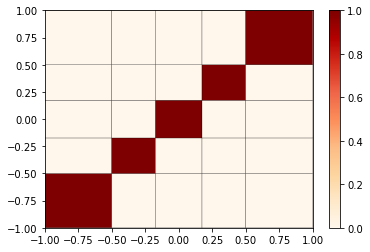

4.042114837147948

In [84]:
total_beamon = [a+b for a,b in zip(fhc_dict['beamon_full_evt_rate'], rhc_dict['beamon_full_evt_rate'])]
total_sim = [a+b for a,b in zip(fhc_dict['full_evt_rate'], rhc_dict['full_evt_rate'])]
total_signal = [(a-b)+(c-d) for a,b,c,d in zip(fhc_dict['full_evt_rate'], fhc_dict['cv_bkgd'], rhc_dict['full_evt_rate'], rhc_dict['cv_bkgd'])]
total_bkgd = [a+b for a,b in zip(fhc_dict['cv_bkgd'], rhc_dict['cv_bkgd'])]

# compute the chi2 

# include beam on stat in the covariance 
cov = ( np.array(tot_frac_cov) + np.array(beamon_frac_stat_cov) )

for i in range(len(bins)-1): 
     for j in range(len(bins)-1): 
            cov[i][j] = cov[i][j] * total_sim[i] * total_sim[j]

# inverse cov
inverse_cov = np.linalg.inv( cov ) 

## check 
plt.pcolor(bins, bins, np.matmul(cov, inverse_cov), cmap='OrRd', edgecolors='k')
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
cbar = plt.colorbar()
plt.show()


chi2 = 0

for i in range(len(bins)-1):  
    for j in range(len(bins)-1):  
            chi2 = chi2  + ( (total_sim[i]-total_beamon[i])*inverse_cov[i][j]*(total_sim[j]-total_beamon[j]) )
chi2




In [85]:
# make a new inverse matrix to use -- delete everything but the first bin
inv = np.delete(np.array(cov), obj=[i for i in range(len(bincenters)) if i>0], axis=0)
inv = np.linalg.inv(np.delete(inv, obj=[i for i in range(len(bincenters)) if i>0], axis=1))

chi2_first = 0

for i in range(len(inv)): 
    for j in range(len(inv)): 
            chi2_first = chi2_first  + ( (total_sim[i]-total_beamon[i])*inv[i][j]*(total_sim[j]-total_beamon[j]) )


print('chi2 -- first bin ONLY :')  
print(round(chi2,1), '(reduced = '+str(round(chi2/len(inv),1))+')')



chi2 -- first bin ONLY :
4.0 (reduced = 4.0)


In [86]:
x_err = []
for x in range(len(bincenters)):
    x_err.append(round(abs((bins[:-1]+[xhigh])[x+1]-(bins[:-1]+[xhigh])[x])/2, 2))

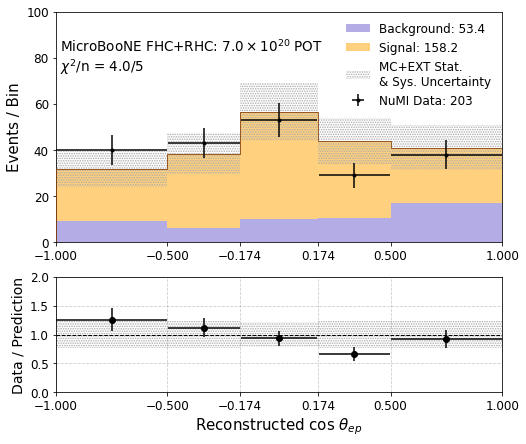

In [90]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
    
ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax1.set_xticks(x_ticks)
ax2.set_xticks(x_ticks)

ax1.set_xlim(bins[0], xhigh)
ax2.set_xlim(bins[0], xhigh)


#### GENIE #####
               
n, b, p = ax1.hist([bincenters, bincenters], bins, histtype='bar', weights=[total_bkgd, total_signal], 
                   stacked=True, color=['slateblue', 'orange'], alpha=0.5,
            label=['Background: '+str(round(sum(total_bkgd), 1)), 'Signal: '+str(round(sum(total_signal), 1))])


sim_err = [x*y for x, y in zip(n[-1], np.sqrt(np.diag(tot_frac_cov)))]

low_err = [ x-y for x,y in zip(n[-1], sim_err) ]
low_err.insert(0, low_err[0])

high_err = [ x+y for x,y in zip(n[-1], sim_err)]
high_err.insert(0, high_err[0])

ax1.fill_between(bins, low_err, high_err, step="pre",
                    facecolor=(.25, .25, .25, 0), 
                     edgecolor='darkgray', 
                     hatch='.....', 
                     linewidth=0.0, zorder=2, 
                     label='MC+EXT Stat.\n& Sys. Uncertainty')

tot = list([0, n[-1][0]])+list(n[-1])+[0]
b_step = list([b[0]])+list(b)+list([b[-1]])
ax1.step(b_step, tot, color='saddlebrown', linewidth=1, zorder=3, alpha=0.85)


#### DATA #####

ax1.errorbar(bincenters, total_beamon, yerr=np.sqrt(total_beamon), xerr=x_err, 
             color="black", fmt='o', markersize=3, label='NuMI Data: '+str(int(sum(total_beamon))), zorder=4)


# ratio plot  
ax2.errorbar(bincenters, total_beamon/n[-1], yerr=get_ratio_err(total_beamon, n[-1]), 
             xerr=x_err, color="black", fmt='o')
ax2.set_ylim(0, 2)

ax2.axhline(1.0, color='black', lw=1, linestyle='--')

# MC ratio error - stat + sys 
low_err_ratio = [ 1 - x for x in np.sqrt(np.diag(tot_frac_cov)) ]
low_err_ratio.insert(0, low_err_ratio[0])
    
high_err_ratio = [ 1 + x for x in np.sqrt(np.diag(tot_frac_cov)) ]
high_err_ratio.insert(0, high_err_ratio[0])

ax2.fill_between(bins, low_err_ratio, high_err_ratio, step="pre", facecolor=(.25, .25, .25, 0), 
                     edgecolor='darkgray',
                     hatch='.....', 
                     linewidth=0.0, zorder=1)
    
ax2.set_xlabel('Reconstructed '+x_label, fontsize=15)
ax2.set_ylabel("Data / Prediction", fontsize=14)

ax1.legend(fontsize=12, frameon=False, loc='upper right')
ax1.set_ylabel("Events / Bin", fontsize=15)
ax1.set_ylim(0, 100)

#ax1.set_title("FHC+RHC Total Selected Event Rate", fontsize=16)

ax1.text(-.98, 74, 
         "MicroBooNE FHC+RHC: $7.0\\times10^{20}$ POT\n$\\chi^{2}$/n = "+str(round(chi2, 1))+"/"+str(len(bins)-1), 
                 fontsize=13.5, horizontalalignment='left')

#ax1.set_title("FHC+RHC Selected Event Rate", fontsize=16)

plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/"+xvar+"_bdtcut_data.svg", bbox_inches='tight')#, dpi=1000) 

plt.show()

In [ ]:
chi2_first

## FHC event rate

In [ ]:
fhc_beamon = fhc_dict['beamon_full_evt_rate']
fhc_signal = [(a-b) for a,b in zip(fhc_dict['full_evt_rate'], fhc_dict['cv_bkgd'])]
fhc_bkgd = fhc_dict['cv_bkgd']

# compute the chi2 

# include beam on stat in the covariance 
fhc_cov = ( np.array(fhc_tot_frac_cov) + np.array(fhc_beamon_frac_stat_cov) )

for i in range(len(bins)-1): 
     for j in range(len(bins)-1): 
            fhc_cov[i][j] = fhc_cov[i][j] * fhc_dict['full_evt_rate'][i] * fhc_dict['full_evt_rate'][j]

# inverse cov
fhc_inverse_cov = np.linalg.inv( fhc_cov ) 

## check 
plt.pcolor(bins, bins, np.matmul(fhc_cov, fhc_inverse_cov), cmap='OrRd', edgecolors='k')
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
cbar = plt.colorbar()
plt.show()


fhc_chi2 = 0

for i in range(len(bins)-1):  
    for j in range(len(bins)-1):  
            fhc_chi2 = fhc_chi2  + ( (fhc_dict['full_evt_rate'][i]-fhc_beamon[i])*fhc_inverse_cov[i][j]*(fhc_dict['full_evt_rate'][j]-fhc_beamon[j]) )
fhc_chi2


In [ ]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)
    
ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax1.set_xticks(x_ticks)
ax2.set_xticks(x_ticks)

ax1.set_xlim(bins[0], xhigh)
ax2.set_xlim(bins[0], xhigh)
               
fhc_n, fhc_b, fhc_p = ax1.hist([bincenters, bincenters], bins, histtype='bar', weights=[fhc_bkgd, fhc_signal], 
                   stacked=True, color=['slateblue', 'orange'], alpha=0.5,
            label=['Bkgd: '+str(round(sum(fhc_bkgd), 1)), 'Signal: '+str(round(sum(fhc_signal), 1))])


fhc_sim_err = [x*y for x, y in zip(fhc_n[-1], np.sqrt(np.diag(fhc_tot_frac_cov)))]

fhc_low_err = [ x-y for x,y in zip(fhc_n[-1], fhc_sim_err) ]
fhc_low_err.insert(0, fhc_low_err[0])

fhc_high_err = [ x+y for x,y in zip(fhc_n[-1], fhc_sim_err)]
fhc_high_err.insert(0, fhc_high_err[0])

ax1.fill_between(bins, fhc_low_err, fhc_high_err, step="pre",
                    facecolor=(.25, .25, .25, 0), 
                     edgecolor='darkgray', 
                     hatch='.....', 
                     linewidth=0.0, zorder=2, 
                     label='MC+EXT Stat.\n& Sys. Uncertainty')

fhc_tot = list([0, fhc_n[-1][0]])+list(fhc_n[-1])+[0]
ax1.step(b_step, fhc_tot, color='saddlebrown', linewidth=1, zorder=3, alpha=0.85)

ax1.errorbar(bincenters, fhc_beamon, yerr=np.sqrt(fhc_beamon), xerr=x_err, 
             color="black", fmt='o', markersize=3, 
             label='DATA: '+str(int(sum(fhc_beamon)))+"\n$\\chi^{2}$/n = "+str(round(fhc_chi2, 1))+"/"+str(len(bins)-1), zorder=4)


# ratio plot  
ax2.errorbar(bincenters, fhc_beamon/fhc_n[-1], yerr=get_ratio_err(fhc_beamon, fhc_n[-1]), xerr=x_err, color="black", fmt='o')
ax2.set_ylim(0, 2)

ax2.axhline(1.0, color='black', lw=1, linestyle='--')

# MC ratio error - stat + sys 
fhc_low_err_ratio = [ 1 - x for x in np.sqrt(np.diag(fhc_tot_frac_cov)) ]
fhc_low_err_ratio.insert(0, fhc_low_err_ratio[0])
    
fhc_high_err_ratio = [ 1 + x for x in np.sqrt(np.diag(fhc_tot_frac_cov)) ]
fhc_high_err_ratio.insert(0, fhc_high_err_ratio[0])

ax2.fill_between(bins, fhc_low_err_ratio, fhc_high_err_ratio, step="pre", facecolor=(.25, .25, .25, 0), 
                     edgecolor='darkgray',
                     hatch='.....', 
                     linewidth=0.0, zorder=1)
    
ax2.set_xlabel('Reconstructed '+x_label, fontsize=15)
ax2.set_ylabel("DATA / (MC+EXT)", fontsize=15)

ax1.legend(fontsize=13, frameon=False)
ax1.set_ylabel("$\\nu$ / 2.0 $\\times 10^{20}$ POT", fontsize=15)


ax1.set_title("FHC Total Selected Event Rate", fontsize=16)
plt.show()

In [ ]:
## purity 


plt.hist()

## RHC Event rate

In [ ]:
rhc_beamon = rhc_dict['beamon_full_evt_rate']
rhc_signal = [(a-b) for a,b in zip(rhc_dict['full_evt_rate'], rhc_dict['cv_bkgd'])]
rhc_bkgd = rhc_dict['cv_bkgd']

# compute the chi2 

# include beam on stat in the covariance 
rhc_cov = ( np.array(rhc_tot_frac_cov) + np.array(rhc_beamon_frac_stat_cov) )

for i in range(len(bins)-1): 
     for j in range(len(bins)-1): 
            rhc_cov[i][j] = rhc_cov[i][j] * rhc_dict['full_evt_rate'][i] * rhc_dict['full_evt_rate'][j]

# inverse cov
rhc_inverse_cov = np.linalg.inv( rhc_cov ) 

## check 
plt.pcolor(bins, bins, np.matmul(rhc_cov, rhc_inverse_cov), cmap='OrRd', edgecolors='k')
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
cbar = plt.colorbar()
plt.show()


rhc_chi2 = 0

for i in range(len(bins)-1):  
    for j in range(len(bins)-1):  
            rhc_chi2 = rhc_chi2  + ( (rhc_dict['full_evt_rate'][i]-rhc_beamon[i])*rhc_inverse_cov[i][j]*(rhc_dict['full_evt_rate'][j]-rhc_beamon[j]) )
rhc_chi2

In [ ]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)
    
ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax1.set_xticks(x_ticks)
ax2.set_xticks(x_ticks)

ax1.set_xlim(bins[0], xhigh)
ax2.set_xlim(bins[0], xhigh)
               
rhc_n, rhc_b, rhc_p = ax1.hist([bincenters, bincenters], bins, histtype='bar', weights=[rhc_bkgd, rhc_signal], 
                   stacked=True, color=['slateblue', 'orange'], alpha=0.5,
            label=['Bkgd: '+str(round(sum(rhc_bkgd), 1)), 'Signal: '+str(round(sum(rhc_signal), 1))])


rhc_sim_err = [x*y for x, y in zip(rhc_n[-1], np.sqrt(np.diag(rhc_tot_frac_cov)))]

rhc_low_err = [ x-y for x,y in zip(rhc_n[-1], rhc_sim_err) ]
rhc_low_err.insert(0, rhc_low_err[0])

rhc_high_err = [ x+y for x,y in zip(rhc_n[-1], rhc_sim_err)]
rhc_high_err.insert(0, rhc_high_err[0])

ax1.fill_between(bins, rhc_low_err, rhc_high_err, step="pre",
                    facecolor=(.25, .25, .25, 0), 
                     edgecolor='darkgray', 
                     hatch='.....', 
                     linewidth=0.0, zorder=2, 
                     label='MC+EXT Stat.\n& Sys. Uncertainty')

rhc_tot = list([0, rhc_n[-1][0]])+list(rhc_n[-1])+[0]
ax1.step(b_step, rhc_tot, color='saddlebrown', linewidth=1, zorder=3, alpha=0.85)

ax1.errorbar(bincenters, rhc_beamon, yerr=np.sqrt(rhc_beamon), xerr=x_err, 
             color="black", fmt='o', markersize=3, 
             label='DATA: '+str(int(sum(rhc_beamon)))+"\n$\\chi^{2}$/n = "+str(round(rhc_chi2, 1))+"/"+str(len(bins)-1), zorder=4)


# ratio plot  
ax2.errorbar(bincenters, rhc_beamon/rhc_n[-1], yerr=get_ratio_err(rhc_beamon, rhc_n[-1]), xerr=x_err, color="black", fmt='o')
ax2.set_ylim(0, 2)

ax2.axhline(1.0, color='black', lw=1, linestyle='--')

# MC ratio error - stat + sys 
rhc_low_err_ratio = [ 1 - x for x in np.sqrt(np.diag(rhc_tot_frac_cov)) ]
rhc_low_err_ratio.insert(0, rhc_low_err_ratio[0])
    
rhc_high_err_ratio = [ 1 + x for x in np.sqrt(np.diag(rhc_tot_frac_cov)) ]
rhc_high_err_ratio.insert(0, rhc_high_err_ratio[0])

ax2.fill_between(bins, rhc_low_err_ratio, rhc_high_err_ratio, step="pre", facecolor=(.25, .25, .25, 0), 
                     edgecolor='darkgray',
                     hatch='.....', 
                     linewidth=0.0, zorder=1)
    
ax2.set_xlabel('Reconstructed '+x_label, fontsize=15)
ax2.set_ylabel("DATA / (MC+EXT)", fontsize=15)

ax1.legend(fontsize=13, frameon=False)
ax1.set_ylabel("$\\nu$ / 5.0 $\\times 10^{20}$ POT", fontsize=15)

ax1.set_title("RHC Total Selected Event Rate", fontsize=16)
plt.show()